In [2]:
import credentials
import twitter_settings  
import imp 
imp.reload(twitter_settings)
imp.reload(credentials)
from twitter_settings import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint
import spacy
import re
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import mysql.connector
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [3]:
stop_words=stopwords.words('english')
stop_words.extend(['netflix','disney','disney+','disneyplus'])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
def connect_db():
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="*******",
        database="TwitterDB",
        auth_plugin='mysql_native_password',
        charset='utf8'  
    )
    
    return mydb

def close_db(mydb):
    mydb.close()

In [5]:
## Open db connection
mydb = connect_db()
netflix_query = "SELECT id_str, created_at, track, text, polarity, compound_score ,negative_score ,positive_score ,neutral_score, hashtags, user_location FROM {} where track like 'Netflix' order by created_at desc" \
                     .format(twitter_settings.HISTORY_TABLE_NAME)
netflix_tweets_df = pd.read_sql(netflix_query,con=mydb)
netflix_tweets_df["created_at"]=netflix_tweets_df.created_at.astype(np.datetime64)
close_db(mydb)
netflix_tweets_df#.head()

id_str          created_at    track  \
0    1199710425379684352 2019-11-27 10:23:49  Netflix   
1    1199710035577839622 2019-11-27 10:22:16  Netflix   
2    1199709953545703430 2019-11-27 10:21:57  Netflix   
3    1199709579984150529 2019-11-27 10:20:28  Netflix   
4    1199709435116965889 2019-11-27 10:19:53  Netflix   
5    1199709109647396864 2019-11-27 10:18:35  Netflix   
6    1199708568217432064 2019-11-27 10:16:26  Netflix   
7    1199708314566823938 2019-11-27 10:15:26  Netflix   
8    1199708274871848961 2019-11-27 10:15:16  Netflix   
9    1199708158328889344 2019-11-27 10:14:49  Netflix   
10   1199707949498654720 2019-11-27 10:13:59  Netflix   
11   1199707557478178819 2019-11-27 10:12:25  Netflix   
12   1199707235468881920 2019-11-27 10:11:09  Netflix   
13   1199706842143719424 2019-11-27 10:09:35  Netflix   
14   1199706726762762240 2019-11-27 10:09:07  Netflix   
15   1199706689731203074 2019-11-27 10:08:58  Netflix   
16   1199706608995127296 2019-11-27 10:08:39  Netflix   
17   1199706105380782082 2019-11-27 10:06:39  Netflix   
18   1199705919564726272 2019-11-27 10:05:55  Netflix   
19   1199705831002050562 2019-11-27 10:05:34  Netflix   
20   1199705828535619584 2019-11-27 10:05:33  Netflix   
21   1199705807492767747 2019-11-27 10:05:28  Netflix   
22   1199705751515742209 2019-11-27 10:05:15  Netflix   
23   1199705741399076866 2019-11-27 10:05:12  Netflix   
24   1199705565389377536 2019-11-27 10:04:30  Netflix   
25   1199705463282995200 2019-11-27 10:04:06  Netflix   
26   1199705460162453510 2019-11-27 10:04:05  Netflix   
27   1199705213432664064 2019-11-27 10:03:06  Netflix   
28   1199705210836246529 2019-11-27 10:03:06  Netflix   
29   1199705016812163073 2019-11-27 10:02:20  Netflix   
30   1199704886327164929 2019-11-27 10:01:48  Netflix   
31   1199704854777741313 2019-11-27 10:01:41  Netflix   
32   1199704783155687430 2019-11-27 10:01:24  Netflix   
33   1199704774146510848 2019-11-27 10:01:22  Netflix   
34   1199704648187293697 2019-11-27 10:00:52  Netflix   
35   1199704540129484803 2019-11-27 10:00:26  Netflix   
36   1199704232091430912 2019-11-27 09:59:13  Netflix   
37   1199704085131227136 2019-11-27 09:58:37  Netflix   
38   1199703661766561792 2019-11-27 09:56:57  Netflix   
39   1199703526630404098 2019-11-27 09:56:24  Netflix   
40   1199703474453258246 2019-11-27 09:56:12  Netflix   
41   1199358897263386624 2019-11-26 11:06:58  Netflix   
42   1199358897221443585 2019-11-26 11:06:58  Netflix   
43   1199358895266967552 2019-11-26 11:06:58  Netflix   
44   1199358895052996608 2019-11-26 11:06:58  Netflix   
45   1199358888975458304 2019-11-26 11:06:56  Netflix   
46   1199358887419400192 2019-11-26 11:06:56  Netflix   
47   1199358886106542080 2019-11-26 11:06:56  Netflix   
48   1199358871376203776 2019-11-26 11:06:52  Netflix   
49   1199358858570977280 2019-11-26 11:06:49  Netflix   
50   1199358854036938753 2019-11-26 11:06:48  Netflix   
51   1199358843433684996 2019-11-26 11:06:45  Netflix   
52   1199358841370140674 2019-11-26 11:06:45  Netflix   
53   1199358838555729920 2019-11-26 11:06:44  Netflix   
54   1199358835179360261 2019-11-26 11:06:43  Netflix   
55   1199358833942048768 2019-11-26 11:06:43  Netflix   
56   1199358831911931910 2019-11-26 11:06:43  Netflix   
57   1199358828841594880 2019-11-26 11:06:42  Netflix   
58   1199358828174667776 2019-11-26 11:06:42  Netflix   
59   1199358823972114434 2019-11-26 11:06:41  Netflix   
60   1199358809539518464 2019-11-26 11:06:37  Netflix   
61   1199358807203291136 2019-11-26 11:06:37  Netflix   
62   1199358799901003777 2019-11-26 11:06:35  Netflix   
63   1199358796604334082 2019-11-26 11:06:34  Netflix   
64   1199358793907363848 2019-11-26 11:06:34  Netflix   
65   1199358781131390978 2019-11-26 11:06:31  Netflix   
66   1199358765713244163 2019-11-26 11:06:27  Netflix   
67   1199358763909701632 2019-11-26 11:06:26  Netflix   
68   1199358762777112576 2019-11-26 11:06:26  Netflix   
69   1199358747673612288 201

In [6]:
tweets_list = netflix_tweets_df['text'].values.tolist()
tweets_list

['THE IRISHMAN is now finally streaming on Netflix Once you ve seen it or if you really don t give a cuss about spoilers rea',
 'hello i need the third season or anne with a e on netflix RIGHT NOW',
 'Because the people who can save it really do have no brains when it comes to this show Or Netflix has something in a c',
 'THE IRISHMAN is on Netflix today You should absolutely watch it if you have any interest in Scorsese gangster movies or',
 'im still not over this can someone give me a movie or a series or SOMETHING netflix marvel',
 'Rainy days are perfect for sad music and binge watching Netflix or Disney',
 'THE IRISHMAN is now finally streaming on Netflix Once you ve seen it or if you really don t give a cuss about spo',
 'Omg i feel the same I sadly still waste hours on Netflix and youtube but at the end of the day',
 'The bread and circuses or in the modern sense the pizza and Netflix have them distrac',
 'whispers pitch it to Netflix or SyFy',
 'So bighit unfollowed Netflix Ko

## Tokenization words and clean up text

In [7]:
def tweets_to_words(tweets):
    for tweet in tweets:
        yield(gensim.utils.simple_preprocess(str(tweet),deacc=True))
tweet_words = list(tweets_to_words(tweets_list))
print(tweet_words)

[['the', 'irishman', 'is', 'now', 'finally', 'streaming', 'on', 'netflix', 'once', 'you', 've', 'seen', 'it', 'or', 'if', 'you', 'really', 'don', 'give', 'cuss', 'about', 'spoilers', 'rea'], ['hello', 'need', 'the', 'third', 'season', 'or', 'anne', 'with', 'on', 'netflix', 'right', 'now'], ['because', 'the', 'people', 'who', 'can', 'save', 'it', 'really', 'do', 'have', 'no', 'brains', 'when', 'it', 'comes', 'to', 'this', 'show', 'or', 'netflix', 'has', 'something', 'in'], ['the', 'irishman', 'is', 'on', 'netflix', 'today', 'you', 'should', 'absolutely', 'watch', 'it', 'if', 'you', 'have', 'any', 'interest', 'in', 'scorsese', 'gangster', 'movies', 'or'], ['im', 'still', 'not', 'over', 'this', 'can', 'someone', 'give', 'me', 'movie', 'or', 'series', 'or', 'something', 'netflix', 'marvel'], ['rainy', 'days', 'are', 'perfect', 'for', 'sad', 'music', 'and', 'binge', 'watching', 'netflix', 'or', 'disney'], ['the', 'irishman', 'is', 'now', 'finally', 'streaming', 'on', 'netflix', 'once', 'you

## Create bigram and trigram models

In [8]:
bigram = gensim.models.Phrases(tweet_words,min_count=5,threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[tweet_words],threshold=100)

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

print(trigram_model[bigram_model[tweet_words[0]]])

['the', 'irishman', 'is', 'now', 'finally', 'streaming', 'on', 'netflix', 'once', 'you', 've', 'seen', 'it', 'or', 'if', 'you', 'really', 'don', 'give', 'cuss', 'about', 'spoilers', 'rea']


## Remove stopwords, lemmatization

In [9]:
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(single_tweet)) 
             if word not in stop_words] for single_tweet in tweets]

def make_bigrams(tweets):
    return [bigram_model[single_tweet] for single_tweet in tweets]

def make_trigrams(tweets):
    return [trigram_model[single_tweet] for single_tweet in tweets]

def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for tweet in tweets:
        doc = nlp(" ".join(tweet)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [10]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['finally', 'stream', 'see', 'really', 'give']]


## Create dictionary and corpus for Topic Modelling

In [11]:
# Create Dictionary
tweetid2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
tweets = tweet_lemmatized

# Term Document Frequency
corpus = [tweetid2word.doc2bow(tweet) for tweet in tweets]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [12]:
tweetid2word[0]

'finally'

In [13]:
# Human readable format of corpus (term-frequency)
[[(tweetid2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('finally', 1), ('give', 1), ('really', 1), ('see', 1), ('stream', 1)]]

In [14]:
def generate_word_cloud_text(tweets):
    text = ' '
    for tweet in tweets:
         # Converts each token into lowercase 
        for i in range(len(tweet)): 
            tweet[i] = tweet[i].lower() 

        for word in tweet: 
            text = text + word + ' '
            
        wc = WordCloud(max_words= 100,
                          width = 744, 
                          height = 544,
                          background_color ='white',
                          stopwords=stop_words, 
                          contour_width=3, 
                          contour_color='steelblue',
                          min_font_size = 10).generate(text) 
    return wc

(-0.5, 743.5, 543.5, -0.5)

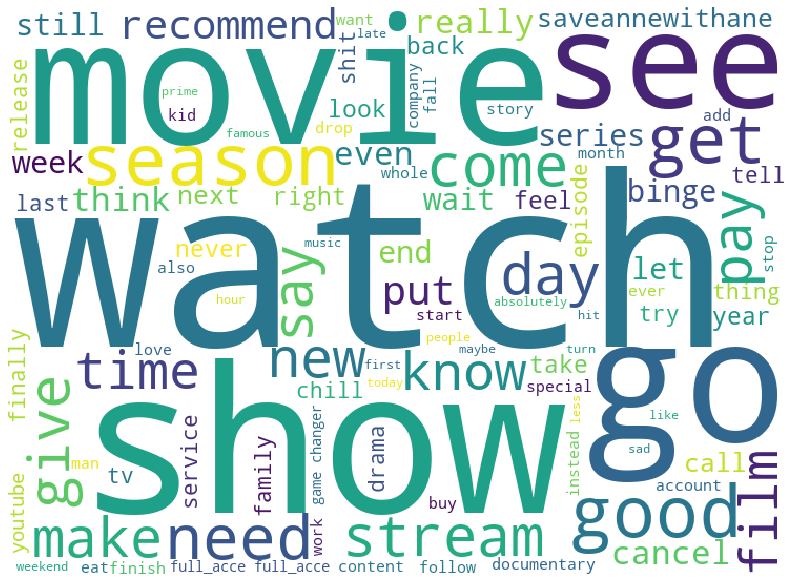

In [15]:
wordcloud_text = generate_word_cloud_text(tweets)
# wordcloud(corpus, min.freq=2, max.words = 150, random.order = TRUE, col = pal)
plt.figure(figsize = (14, 14)) 
plt.imshow(wordcloud_text) 
plt.axis("off")
#plt.savefig('./images/twitter_wordcloud.png')

## Build Topic Model

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweetid2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
tweet_lda = lda_model[corpus]

[(0,
  '0.062*"use" + 0.061*"tv" + 0.036*"youtube" + 0.011*"interact" + '
  '0.011*"catch" + 0.011*"hear" + 0.011*"issue" + 0.011*"agree" + '
  '0.011*"longer" + 0.011*"newspaper"'),
 (1,
  '0.126*"pay" + 0.066*"year" + 0.045*"binge" + 0.029*"life" + 0.028*"music" + '
  '0.028*"sad" + 0.022*"perfect" + 0.018*"day" + 0.018*"co" + 0.016*"watch"'),
 (2,
  '0.107*"look" + 0.075*"end" + 0.063*"right" + 0.043*"late" + 0.042*"drama" + '
  '0.019*"world" + 0.009*"pour" + 0.009*"sur" + 0.009*"piece" + '
  '0.009*"fucking"'),
 (3,
  '0.278*"movie" + 0.192*"good" + 0.047*"horror" + 0.045*"recommend" + '
  '0.001*"junk" + 0.001*"food" + 0.001*"straight" + 0.001*"man" + 0.001*"mind" '
  '+ 0.001*"cute"'),
 (4,
  '0.193*"get" + 0.068*"service" + 0.039*"see" + 0.027*"date" + 0.024*"first" '
  '+ 0.015*"btw" + 0.015*"nex" + 0.015*"wait" + 0.015*"deserve" + '
  '0.015*"course"'),
 (5,
  '0.115*"day" + 0.099*"really" + 0.042*"let" + 0.027*"find" + 0.022*"social" '
  '+ 0.019*"finally" + 0.010*"touch" + 

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, 
                                     dictionary=tweetid2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.857256893169335

Coherence Score:  0.4192698314707532


In [22]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1)],
 [(2, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(1, 1), (17, 1), (21, 1), (22, 1), (23, 1), (24, 1)],
 [(20, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(24, 1),
  (26, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)],
 [(44, 1), (45, 1), (46, 1)],
 [(47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)],
 [(31, 1), (53, 1), (54, 1), (55, 1)],
 [(3, 1), (56, 1)],
 [(17, 1), (57, 1)],
 [(20, 2), (58, 1), (59, 1), (60, 1)],
 [(5, 1)],
 [(54, 1), (61, 1), (62, 1), (63, 1), (64, 1)],
 [(17, 1), (19, 1), (20, 1), (65, 1), (66, 1)],
 [(21, 1), (67, 1), (68, 1), (69, 1)],
 [(70, 1), (71, 1), (72, 1), (73, 1), (74, 1)],
 [(7, 2), (13, 1), (32, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)],
 [(13

## Make dataframe of topic words and weights

In [187]:
lda_topics_list = lda_model.print_topics()
col_list=[]
for i in range(0,len(lda_topics_list)):
    colname1 = 'Topic_' + str(i) + '_words'
    colname2 = 'Topic_' + str(i) + '_weights'
    col_list.append(colname1)
    col_list.append(colname2)
topic_df = pd.DataFrame(columns=col_list)
for i in range(0,len(lda_topics_list)):
    topics_words_list = lda_topics_list[i][1].split('+')
    weights_list=[]
    topicword_list=[]
    for word in topics_words_list:
        weight = float(word.split('*')[0].strip())
        topicword = word.split('*')[1].strip().strip('"')
        weights_list.append(weight)
        topicword_list.append(topicword)
    topic_df['Topic_' + str(i) + '_words'] = pd.Series(topicword_list)
    topic_df['Topic_' + str(i) + '_weights'] = pd.Series(weights_list)
topic_df

Topic_0_words  Topic_0_weights   Topic_1_words  Topic_1_weights  \
0          come            0.147           watch            0.351   
1          fall            0.043              be            0.098   
2         movie            0.034              go            0.051   
3          drop            0.028  recommendation            0.026   
4          week            0.028           movie            0.024   
5           new            0.020             way            0.013   
6     burlesque            0.020            time            0.008   
7         money            0.020            room            0.008   
8         right            0.020       projector            0.008   
9          film            0.020       countless            0.008   

  Topic_2_words  Topic_2_weights Topic_3_words  Topic_3_weights Topic_4_words  \
0          make            0.174         chill            0.116        season   
1          take            0.066          time            0.072         movie   
2         thing            0.055          star            0.024          look   
3           boy            0.028        bottle            0.012        stream   
4          cool            0.012         water            0.012          free   
5           see            0.012          wine            0.012        switch   
6          hero            0.012           hot            0.012      download   
7         super            0.012         night            0.012           buy   
8         great            0.012          role            0.012       service   
9     classroom            0.012          teen            0.012       trailer   

   Topic_4_weights Topic_5_words  Topic_5_weights Topic_6_words  \
0            0.097          show            0.224        direct   
1            0.086          good            0.116         major   
2            0.066          film            0.088     catalogue   
3            0.059           new            0.055   documentary   
4            0.049          girl            0.029   performance   
5            0.049          also            0.023          kill   
6            0.049          turn            0.019        nearly   
7            0.032           yet            0.019           ban   
8            0.024      dinosaur            0.008        harder   
9            0.024           mad            0.008     beautiful   

   Topic_6_weights Topic_7_words  Topic_7_weights Topic_8_words  \
0            0.002       account            0.133           pay   
1            0.002       premium            0.044           man   
2            0.002        really            0.031       certain   
3            0.002      upcoming            0.014          love   
4            0.002      thriller            0.014          lose   
5            0.002      survival            0.014          back   
6            0.002           pro            0.014          text   
7            0.002      fortnite            0.014       youtube   
8            0.002         title            0.014        really   
9            0.002     unchecked            0.014         pause   

   Topic_8_weights Topic_9_words  Topic_9_weights Topic_10_words  \
0            0.225            go            0.124              s   
1            0.094         watch            0.050          watch   
2            0.070       changer            0.049            see   
3            0.034          game            0.049           full   
4            0.021        people            0.023           next   
5            0.009       special            0.023           door   
6            0.009            co            0.010            try   
7            0.009    adaptation            0.010         better   
8            0.009        victor            0.010          world   
9            0.009         happy            0.010        western   

   Topic_10_weights Topic_11_words  Topic_11_weights Topic_12_words  \
0             0.166           even             0.113  

In [188]:
max(topic_df)

'Topic_9_words'

## Dominant topic in each tweet

In [1]:
corpus

NameError: name 'corpus' is not defined

In [205]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tweets_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tweets_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            14.0              0.8915   
1            1            16.0              0.5782   
2            2            10.0              0.6173   
3            3             0.0              0.6078   
4            4             9.0              0.8045   
5            5            11.0              0.7491   
6            6            12.0              0.8057   
7            7             9.0              0.5158   
8            8             3.0              0.8763   
9            9            14.0              0.8779   

                                            Keywords  \
0  want, full_acce, release, official, series, fi...   
1  stream, stop, amazing, spend, addition, imagin...   
2  s, watch, see, full, next, door, try, better, ...   
3  come, fall, movie, drop, week, new, burlesque,...   
4  go, watch, changer, game, people, special, co,...   
5  even, day, put, original, straight, future, wa...   
6  say, cancel, movie, actually, ray, part, spoti...   
7  go, watch, changer, game, people, special, co,...   
8  chill, time, star, bottle, water, wine, hot, n...   
9  want, full_acce, release, official, series, fi...   

                                                Text  
0  SORTEO RANDOM SEMI FULL ACCES UNMIGRATED FULL ...  
1  Xadia awaits The Dragon Prince season 3 is NOW...  
2  I didnt know the full story of Ivan the Terrib...  
3  netflix and chill hulu and woohoo amazon prime...  
4  Happy Birthday to The Black Kaiser himself Fro...  
5  netflix originals are great until you binge wa...  
6  fenty girl its 20 if its hard they can cancel ...  
7                                  Netflix had to go  
8  Friday night chilling Netflix hot water bottle...  
9  SORTEO RANDOM SEMI FULL ACCES UNMIGRATED FULL ...

## Most representative topic for each tweet

In [206]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.8923   
1        1.0              0.8101   
2        2.0              0.8773   
3        3.0              0.8763   
4        4.0              0.7667   

                                            Keywords  \
0  come, fall, movie, drop, week, new, burlesque,...   
1  watch, be, go, recommendation, movie, way, tim...   
2  make, take, thing, boy, cool, see, hero, super...   
3  chill, time, star, bottle, water, wine, hot, n...   
4  season, movie, look, stream, free, switch, dow...   

                                                Text  
0  From hot to toxic yoga a new Netflix film docu...  
1  when that kpop boy have his own projector in h...  
2  Have you seen The Boys yet It s great Cool tak...  
3  Friday night chilling Netflix hot water bottle...  
4  Now streaming on Netflix K ON Seasons 1 amp 2 ...

## Topic 0

In [189]:
topic_value='0'
topic_visual_df = topic_df[['Topic_0_words','Topic_0_weights']].reset_index(drop=True)
#topic_visual_df.rename(columns={'Topic_0_words':'word','Topic_0_weights':'weight'},inplace=True)
topic_visual_df

Topic_0_words  Topic_0_weights
0          come            0.147
1          fall            0.043
2         movie            0.034
3          drop            0.028
4          week            0.028
5           new            0.020
6     burlesque            0.020
7         money            0.020
8         right            0.020
9          film            0.020

In [190]:
topic_visual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
Topic_0_words      10 non-null object
Topic_0_weights    10 non-null float64
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


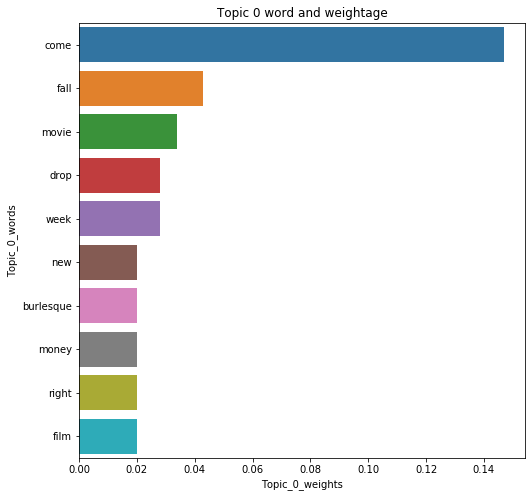

In [192]:
plt.figure(figsize=(8,8))
plt.title('Topic {0} word and weightage'.format(topic_value))
sns.barplot(y='Topic_0_words',x='Topic_0_weights',data=topic_visual_df);

## Select row1 being the heighest weightage row from all topics

In [100]:
row1 = topic_df.loc[0]
print(type(row1))
row1

<class 'pandas.core.series.Series'>


Topic_0_words          come
Topic_0_weights       0.147
Topic_1_words         watch
Topic_1_weights       0.351
Topic_2_words          make
Topic_2_weights       0.174
Topic_3_words         chill
Topic_3_weights       0.116
Topic_4_words        season
Topic_4_weights       0.097
Topic_5_words          show
Topic_5_weights       0.224
Topic_6_words        direct
Topic_6_weights       0.002
Topic_7_words       account
Topic_7_weights       0.133
Topic_8_words           pay
Topic_8_weights       0.225
Topic_9_words            go
Topic_9_weights       0.124
Topic_10_words            s
Topic_10_weights      0.166
Topic_11_words         even
Topic_11_weights      0.113
Topic_12_words          say
Topic_12_weights      0.175
Topic_13_words         step
Topic_13_weights      0.034
Topic_14_words         want
Topic_14_weights      0.104
Topic_15_words         need
Topic_15_weights      0.155
Topic_16_words       stream
Topic_16_weights      0.118
Topic_17_words          get
Topic_17_weights    

In [123]:
topicwords_list=[]
topicwords_weight_list=[]
for i in range(0,len(lda_topics_list)):
    word_subset = row1['Topic_'+str(i)+'_words'].values[0]
    topicwords_list.append(word_subset)
    weight_subset = row1['Topic_'+str(i)+'_weights'].values[0]
    topicwords_weight_list.append(weight_subset)
subtopic_df = pd.DataFrame(columns=['word','weight'])
subtopic_df['word'] = topicwords_list
subtopic_df['weight'] = topicwords_weight_list
subtopic_df = subtopic_df.sort_values(by='weight',ascending=False).reset_index(drop=True)
subtopic_df

word  weight
0     watch   0.351
1       pay   0.225
2      show   0.224
3       get   0.221
4       say   0.175
5      make   0.174
6         s   0.166
7      need   0.155
8      come   0.147
9   account   0.133
10       go   0.124
11   stream   0.118
12    chill   0.116
13     even   0.113
14     want   0.104
15   season   0.097
16     sign   0.082
17     step   0.034
18   direct   0.002
19   direct   0.002

In [180]:
subtopic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
word      20 non-null object
weight    20 non-null float64
dtypes: float64(1), object(1)
memory usage: 400.0+ bytes


In [124]:
subtopic_df['word'][0]

'watch'

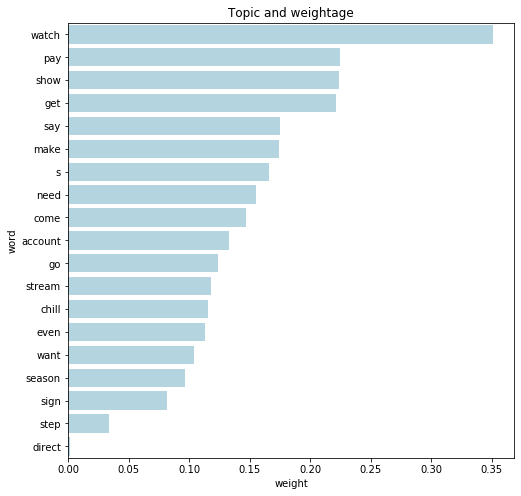

In [174]:
plt.figure(figsize=(8,8))
plt.title('Topic and weightage')
sns.barplot(y='word',x='weight',data=subtopic_df,color='lightblue');

## check for the tweets where most weighted topic has occured

In [138]:
netflix_subset_df=netflix_tweets_df[netflix_tweets_df['text'].str.contains(subtopic_df['word'][0])]
print('total no of tweets with word "{0}": {1}'.format(subtopic_df['word'][0],netflix_subset_df.shape[0]))
netflix_subset_df

total no of tweets with word "watch": 29


id_str          created_at    track  \
2    1198028363551641600 2019-11-22 18:59:54  Netflix   
5    1198028348473004033 2019-11-22 18:59:51  Netflix   
18   1198028289232769025 2019-11-22 18:59:37  Netflix   
28   1198028177811103744 2019-11-22 18:59:10  Netflix   
37   1198028093941829632 2019-11-22 18:58:50  Netflix   
38   1197665994937917440 2019-11-21 18:59:59  Netflix   
39   1197665991695753217 2019-11-21 18:59:58  Netflix   
46   1197665946426474496 2019-11-21 18:59:47  Netflix   
47   1197665927480979457 2019-11-21 18:59:43  Netflix   
58   1197665875488387072 2019-11-21 18:59:30  Netflix   
70   1197665786992766978 2019-11-21 18:59:09  Netflix   
76   1197303580895531008 2019-11-20 18:59:53  Netflix   
78   1197303574482452480 2019-11-20 18:59:51  Netflix   
118  1196941036431577088 2019-11-19 18:59:15  Netflix   
123  1196578831315939328 2019-11-18 18:59:59  Netflix   
132  1196578791734296577 2019-11-18 18:59:49  Netflix   
135  1196578778132049920 2019-11-18 18:59:46  Netflix   
137  1196578773539229696 2019-11-18 18:59:45  Netflix   
147  1196578746687459331 2019-11-18 18:59:39  Netflix   
149  1196578737720041474 2019-11-18 18:59:37  Netflix   
162  1196578653011734528 2019-11-18 18:59:16  Netflix   
163  1196578642979180550 2019-11-18 18:59:14  Netflix   
171  1196578587819819008 2019-11-18 18:59:01  Netflix   
175  1196578537731432448 2019-11-18 18:58:49  Netflix   
189  1195491589042384898 2019-11-15 18:59:40  Netflix   
201  1195491542456246273 2019-11-15 18:59:29  Netflix   
202  1195491540082122752 2019-11-15 18:59:28  Netflix   
207  1195491523808247808 2019-11-15 18:59:25  Netflix   
220  1195491435526537216 2019-11-15 18:59:04  Netflix   

                                                  text  polarity  \
2    I didnt know the full story of Ivan the Terrib...        -1   
5    netflix originals are great until you binge wa...         1   
18   when that kpop boy have his own projector in h...         0   
28   So I ve been watching alot of movies on netfli...         0   
37   Netflix does not show weekly episodes until th...         1   
38   It makes me sad that my only way of watching t...        -1   
39   So DragRaceUK finished think I m gonna binge w...         0   
46   No way im watching that kay haha My kids would...         1   
47                          Im in bed watching Netflix         0   
58   The 30 for 30 podcast was just wow but this do...         1   
70   T Mobile service came a long way Im watching N...         0   
76   How to be a player is on Netflix thanks to BET...         1   
78   you clowning me for not having watched age of ...         0   
118  Everyone watch game changers on Netflix if you...         1   
123  Im watching every single Christmas movie Netfl...         0   
132  Ivr been waiting for that but I can t watch ye...         0   
135                       me too watched it on Netflix         0   
137  banning Netflix isnt going to get people to wa...        -1   
147  I m sick of Netflix asking me every 3 episodes...        -1   
149  Been watching 60 Days In Jail on Netflix the l...        -1   
162  personally i love browsing netflix for an hour...         1   
163  For anyone looking for a good show on Netflix ...         1   
171  So me and my bf were watching this show on Net...        -1   
175  Bro just watch it on Netflix and it will open ...         0   
189  Fractured is the craziest shit I ever watched ...        -1   
201  Group of teenagers watch Netflix on a tiny pho...         0   
202  mark is so cute T T he uses tens netflix accou...         1   
207  what i want to watch sunset netflix you while ...         1   
220  I m watching some horror on Netflix to recover...        -1   

     compound_score  negative_score  positive_score  neutral_score  \
2           -0.8462           0.280           0.000          0.720   
5            0.6249           0.000           0.141          0.859   
18           0.0000           0.000           0.000     

## check for the polarity of tweets where most weighted topic has occured

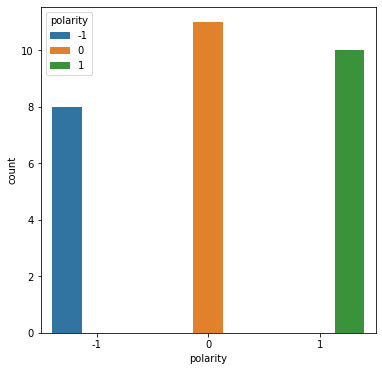

In [136]:
plt.figure(figsize=(6,6))
sns.countplot(x='polarity',data=netflix_subset_df,hue='polarity');
#plt.xticks(['negative','neutral','positive'])

In [144]:
netflix_short_tweets_df = netflix_tweets_df.copy()
netflix_short_tweets_df["tweet_len"] = netflix_tweets_df['text'].apply(lambda x: len(x.split()))
netflix_short_tweets_df

id_str          created_at    track  \
0    1198028375899693056 2019-11-22 18:59:57  Netflix   
1    1198028367456604166 2019-11-22 18:59:55  Netflix   
2    1198028363551641600 2019-11-22 18:59:54  Netflix   
3    1198028356266184708 2019-11-22 18:59:53  Netflix   
4    1198028349320257538 2019-11-22 18:59:51  Netflix   
5    1198028348473004033 2019-11-22 18:59:51  Netflix   
6    1198028345218338818 2019-11-22 18:59:50  Netflix   
7    1198028343582642183 2019-11-22 18:59:50  Netflix   
8    1198028339061182464 2019-11-22 18:59:48  Netflix   
9    1198028338301935616 2019-11-22 18:59:48  Netflix   
10   1198028337886703617 2019-11-22 18:59:48  Netflix   
11   1198028337676992512 2019-11-22 18:59:48  Netflix   
12   1198028328789303296 2019-11-22 18:59:46  Netflix   
13   1198028312414543872 2019-11-22 18:59:42  Netflix   
14   1198028307054260226 2019-11-22 18:59:41  Netflix   
15   1198028304797904902 2019-11-22 18:59:40  Netflix   
16   1198028295670886400 2019-11-22 18:59:38  Netflix   
17   1198028295339696133 2019-11-22 18:59:38  Netflix   
18   1198028289232769025 2019-11-22 18:59:37  Netflix   
19   1198028256362082305 2019-11-22 18:59:29  Netflix   
20   1198028243804160000 2019-11-22 18:59:26  Netflix   
21   1198028217401184256 2019-11-22 18:59:19  Netflix   
22   1198028207418679298 2019-11-22 18:59:17  Netflix   
23   1198028207154315265 2019-11-22 18:59:17  Netflix   
24   1198028189743927296 2019-11-22 18:59:13  Netflix   
25   1198028189081198592 2019-11-22 18:59:13  Netflix   
26   1198028185495052288 2019-11-22 18:59:12  Netflix   
27   1198028185482473477 2019-11-22 18:59:12  Netflix   
28   1198028177811103744 2019-11-22 18:59:10  Netflix   
29   1198028170575769601 2019-11-22 18:59:08  Netflix   
30   1198028169107820544 2019-11-22 18:59:08  Netflix   
31   1198028128284794880 2019-11-22 18:58:58  Netflix   
32   1198028126162477063 2019-11-22 18:58:58  Netflix   
33   1198028120751824898 2019-11-22 18:58:56  Netflix   
34   1198028116192423936 2019-11-22 18:58:55  Netflix   
35   1198028102263332869 2019-11-22 18:58:52  Netflix   
36   1198028099608338432 2019-11-22 18:58:51  Netflix   
37   1198028093941829632 2019-11-22 18:58:50  Netflix   
38   1197665994937917440 2019-11-21 18:59:59  Netflix   
39   1197665991695753217 2019-11-21 18:59:58  Netflix   
40   1197665990676566016 2019-11-21 18:59:58  Netflix   
41   1197665980027158528 2019-11-21 18:59:55  Netflix   
42   1197665979628695553 2019-11-21 18:59:55  Netflix   
43   1197665977137324034 2019-11-21 18:59:55  Netflix   
44   1197665969684074497 2019-11-21 18:59:53  Netflix   
45   1197665954898927616 2019-11-21 18:59:49  Netflix   
46   1197665946426474496 2019-11-21 18:59:47  Netflix   
47   1197665927480979457 2019-11-21 18:59:43  Netflix   
48   1197665924280733697 2019-11-21 18:59:42  Netflix   
49   1197665923487813632 2019-11-21 18:59:42  Netflix   
50   1197665919495032834 2019-11-21 18:59:41  Netflix   
51   1197665914965155841 2019-11-21 18:59:40  Netflix   
52   1197665912070918150 2019-11-21 18:59:39  Netflix   
53   1197665902281531392 2019-11-21 18:59:37  Netflix   
54   1197665895180427264 2019-11-21 18:59:35  Netflix   
55   1197665894073282560 2019-11-21 18:59:35  Netflix   
56   1197665887811059712 2019-11-21 18:59:33  Netflix   
57   1197665880957579264 2019-11-21 18:59:32  Netflix   
58   1197665875488387072 2019-11-21 18:59:30  Netflix   
59   1197665868492095488 2019-11-21 18:59:29  Netflix   
60   1197665866785214465 2019-11-21 18:59:28  Netflix   
61   1197665863836434432 2019-11-21 18:59:28  Netflix   
62   1197665861475041280 2019-11-21 18:59:27  Netflix   
63   1197665856425205763 2019-11-21 18:59:26  Netflix   
64   1197665842789539845 2019-11-21 18:59:23  Netflix   
65   1197665828231102464 2019-11-21 18:59:19  Netflix   
66   1197665826217889794 2019-11-21 18:59:19  Netflix   
67   1197665812636680197 2019-11-21 18:59:15  Netflix   
68   1197665808027209729 2019-11-21 18:59:14  Netflix   
69   1197665795872038913 201

## LDA Mallet Model

In [204]:
# import os

# os.environ['MALLET_HOME'] = '/Users/vidhu/GA-classes/Vidhu-Capstone/Twitter/MediaTwitter/mallet-2.0.8/'
# mallet_path = './mallet-2.0.8/bin/mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus,
#                                            id2word=tweetid2word,num_topics=20)